### Evaluate Noise2Self on Leo-cropped dataset (reconstructable, counts-space)

This notebook is for evaluating denoising on a 4D scan stack stored in HDF5 with shape `(sy, sx, dety, detx)`.

You can:
- interactively view **input / denoised / residual** in **counts** (or `log1p(counts)`)
- overlay **center-of-mass (CoM)** markers for input vs denoised and see the shift
- compute **full-scan CoM overlay maps** (fast path if you have a GPU)
- do **Option B (CPU-only)**: compare **original H5 vs denoised H5** without running the model



In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import h5py
import ipywidgets as widgets
import torch

from IPython.display import display

# ---- Ensure repo root is importable (so `import mask`, `import models.*` work) ----
_repo = None
for p in [Path.cwd(), *Path.cwd().parents]:
    if (p / "mask.py").exists() and (p / "train_noise2self.py").exists():
        _repo = p
        break
if _repo is None:
    raise RuntimeError(
        "Could not find repo root. Run this notebook from inside the repo, "
        "or edit the path logic to point at the noise2self repository."
    )
if str(_repo) not in sys.path:
    sys.path.insert(0, str(_repo))

from mask import Masker
from models.unet import Unet
from models.babyunet import BabyUnet
from models.dncnn import DnCNN
from models.singleconv import SingleConvolution

print("repo root:", _repo)



repo root: d:\Project_PostDoc\Hackathon\noise2self


In [2]:
# ---- Paths (edit these) ----
# IMPORTANT: this notebook runs on *your current machine*.
# - If the .h5 lives on the cluster under /ptmp, either copy it locally or run this notebook on the cluster.

H5_PATHS = [
    r"D:\Project_PostDoc\Hackathon\denoising_Dataset\data\000278_thresholded_p9999_crop50-450_10-500.h5"
]
H5_PATH = next((p for p in H5_PATHS if os.path.exists(p)), H5_PATHS[-1])

# Checkpoint (local path if you've copied it; otherwise run this notebook where ckpt is accessible)
CKPT_PATH = r"D:\Project_PostDoc\Hackathon\old_runs\sort\reconst\ckpt_best.pt"

# HDF5 dataset key candidates
H5_KEY_CANDIDATES = ["data", "/data", "X", "/X"]

# Device (GPU if available, otherwise CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Display defaults
CMAP = "terrain"
RESID_CMAP = "coolwarm"

# Percentiles used for visualization
DEFAULT_VMAX_PCT = 99.9
DEFAULT_RESID_PCT = 99.0

print("H5_PATH:", H5_PATH)
print("H5 exists:", os.path.exists(H5_PATH))
print("CKPT_PATH:", CKPT_PATH)
print("CKPT exists:", os.path.exists(CKPT_PATH))
print("device:", DEVICE)

if not os.path.exists(H5_PATH):
    raise FileNotFoundError(
        "H5 file not found. If you trained/saved it on the cluster under /ptmp, either:\n"
        "  (1) copy it to your local machine and update H5_PATHS, or\n"
        "  (2) run this notebook on the cluster where /ptmp is visible.\n\n"
        f"Tried: {H5_PATHS}"
    )

if not os.path.exists(CKPT_PATH):
    raise FileNotFoundError(
        "Checkpoint not found at CKPT_PATH. Update CKPT_PATH to point to ckpt_epoch*.pt or ckpt_best.pt"
    )



H5_PATH: D:\Project_PostDoc\Hackathon\denoising_Dataset\data\000278_thresholded_p9999_crop50-450_10-500.h5
H5 exists: True
CKPT_PATH: D:\Project_PostDoc\Hackathon\old_runs\sort\reconst\ckpt_best.pt
CKPT exists: True
device: cuda


In [3]:
# ---- Open HDF5 lazily ----
_h5 = h5py.File(H5_PATH, "r")

_dset = None
for k in H5_KEY_CANDIDATES:
    if k in _h5:
        _dset = _h5[k]
        break
assert _dset is not None, f"Could not find dataset key in {list(_h5.keys())}"

sy, sx, dety, detx = (int(x) for x in _dset.shape)
dtype = _dset.dtype

# Optional precomputed maps (if created by SaveThresholdedFrames.ipynb)
_total_real = _h5["real_space_sum_thresholded"][:] if "real_space_sum_thresholded" in _h5 else None

print("dataset key:", _dset.name)
print("shape (sy,sx,dety,detx):", (sy, sx, dety, detx))
print("dtype:", dtype)
print("has real_space_sum_thresholded:", _total_real is not None)



dataset key: /data
shape (sy,sx,dety,detx): (141, 121, 400, 490)
dtype: uint16
has real_space_sum_thresholded: True


In [4]:
# ---- Load checkpoint + build model ----
ckpt = torch.load(CKPT_PATH, map_location="cpu")
cfg = ckpt.get("config", {}) or {}

model_name = str(cfg.get("model", "unet")).lower()
in_ch = int(cfg.get("in_channels", 1))
out_ch = int(cfg.get("out_channels", 1))
include_mask_as_input = bool(cfg.get("include_mask_as_input", False))
masker_width = int(cfg.get("masker_width", 4))
masker_mode = str(cfg.get("masker_mode", "interpolate"))

if model_name == "unet":
    model = Unet(in_ch, out_ch)
elif model_name in {"babyunet", "baby-unet"}:
    model = BabyUnet(in_ch, out_ch)
elif model_name in {"dncnn"}:
    model = DnCNN(channels=in_ch)  # repo's notebook-style API
elif model_name in {"conv", "convolution", "singleconv"}:
    model = SingleConvolution(in_ch, out_ch, width=3)
else:
    raise ValueError(f"Unknown model in ckpt config: {model_name!r}")

model.load_state_dict(ckpt["state_dict"], strict=True)
model.to(DEVICE)
model.eval()

masker = Masker(
    width=masker_width,
    mode=masker_mode,
    infer_single_pass=True,
    include_mask_as_input=include_mask_as_input,
)

print("Loaded ckpt:", CKPT_PATH)
print("model:", model_name, "in_ch=", in_ch, "out_ch=", out_ch)
print("masker:", f"width={masker_width}", f"mode={masker_mode}", f"include_mask_as_input={include_mask_as_input}")



C:\Users\k.umate\AppData\Local\Temp\ipykernel_35412\575220976.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location="cpu")


Loaded ckpt: D:\Project_PostDoc\Hackathon\old_runs\sort\reconst\ckpt_best.pt
model: unet in_ch= 1 out_ch= 1
masker: width=4 mode=interpolate include_mask_as_input=False


In [5]:
def _pad_to_multiple_2d(x: np.ndarray, mult: int = 16, *, mode: str = "constant", constant_values: float = 0.0):
    """Pad a (H,W) array so H and W are divisible by mult. Returns (x_pad, pads)."""
    assert x.ndim == 2
    h, w = x.shape
    pad_h = (mult - (h % mult)) % mult
    pad_w = (mult - (w % mult)) % mult

    pad_top = pad_h // 2
    pad_bot = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    if pad_h == 0 and pad_w == 0:
        return x, (0, 0, 0, 0)

    x_pad = np.pad(
        x,
        ((pad_top, pad_bot), (pad_left, pad_right)),
        mode=mode,
        constant_values=constant_values if mode == "constant" else 0.0,
    )
    return x_pad, (pad_top, pad_bot, pad_left, pad_right)


def _unpad_2d(x_pad: np.ndarray, pads):
    pad_top, pad_bot, pad_left, pad_right = pads
    if pad_top == pad_bot == pad_left == pad_right == 0:
        return x_pad
    h, w = x_pad.shape
    return x_pad[pad_top : h - pad_bot, pad_left : w - pad_right]


# ---- Normalization/scaling (match training config stored in checkpoint) ----
NORMALIZE_MODE = str(cfg.get("normalize", "percentile")).lower()
SCALE_INTEGERS = bool(cfg.get("scale_integers", True))


def _normalize_percentile_2d(x: np.ndarray, *, pmin: float = 1.0, pmax: float = 99.0, eps: float = 1e-6):
    lo = float(np.percentile(x, pmin))
    hi = float(np.percentile(x, pmax))
    return (x - lo) / (hi - lo + eps)


def _normalize_minmax_2d(x: np.ndarray, *, eps: float = 1e-6) -> np.ndarray:
    mn = float(np.min(x))
    mx = float(np.max(x))
    return (x - mn) / (mx - mn + eps)


def to_model_space(x_counts: np.ndarray) -> np.ndarray:
    """Convert float32 counts (H,W) into the numeric space the model expects."""
    x = np.asarray(x_counts, dtype=np.float32)

    if SCALE_INTEGERS and np.issubdtype(dtype, np.integer):
        info = np.iinfo(dtype)
        x = x / float(info.max)

    if NORMALIZE_MODE == "percentile":
        x = _normalize_percentile_2d(x, pmin=1.0, pmax=99.0)
    elif NORMALIZE_MODE == "minmax":
        x = _normalize_minmax_2d(x)
    elif NORMALIZE_MODE == "none":
        pass
    else:
        raise ValueError(f"Unknown normalize mode in ckpt config: {NORMALIZE_MODE!r}")

    return np.asarray(x, dtype=np.float32)


def load_frame_counts(y: int, x: int) -> np.ndarray:
    """Load one detector frame from HDF5 as float32 counts (no extra normalization)."""
    arr = _dset[int(y), int(x)]
    return np.asarray(arr, dtype=np.float32)


@torch.no_grad()
def denoise_frame_model_space(x_counts_2d: np.ndarray, *, pad_mode: str = "constant") -> np.ndarray:
    """Run Noise2Self inference for a single (H,W) float32 counts image.

    Returns model output in *model space* (same space as training input/target).
    """
    x_model = to_model_space(x_counts_2d)
    x_pad, pads = _pad_to_multiple_2d(x_model, 16, mode=pad_mode, constant_values=0.0)

    xt = torch.from_numpy(x_pad[None, None, ...]).to(DEVICE)  # (1,1,H,W)
    use_amp = bool(DEVICE.type == "cuda")
    with torch.amp.autocast(device_type=DEVICE.type, enabled=use_amp):
        yt = masker.infer_full_image(xt, model)
    y = yt.detach().to("cpu").float().numpy()[0, 0]
    y = _unpad_2d(y, pads)
    return np.asarray(y, dtype=np.float32)



In [6]:
# Optional: estimate a global vmax from a small sample (for stable colorbars)

def estimate_global_vmax(*, n_samples: int = 12, vmax_pct: float = 99.9, seed: int = 0) -> float:
    rng = np.random.default_rng(int(seed))
    ys = rng.integers(0, sy, size=n_samples)
    xs = rng.integers(0, sx, size=n_samples)

    vals = []
    for y, x in zip(ys, xs):
        frame = load_frame_counts(int(y), int(x))
        vals.append(frame.ravel())
    flat = np.concatenate(vals, axis=0)
    return float(np.percentile(flat, float(vmax_pct)))


GLOBAL_VMAX_COUNTS = estimate_global_vmax(n_samples=12, vmax_pct=99.9, seed=0)
print("GLOBAL_VMAX_COUNTS (p99.9 from sample):", GLOBAL_VMAX_COUNTS)



GLOBAL_VMAX_COUNTS (p99.9 from sample): 0.0


In [7]:
def _compute_vmin_vmax(
    *,
    mode: str,
    input_counts: np.ndarray,
    denoised_counts: np.ndarray,
    vmax_pct: float,
    log_view: bool,
):
    """Return (vmin_in, vmax_in, vmin_dn, vmax_dn) for display."""
    mode = str(mode)
    vmax_pct = float(vmax_pct)

    if log_view:
        in_view = np.log1p(np.clip(input_counts, 0, None))
        dn_view = np.log1p(np.clip(denoised_counts, 0, None))
    else:
        in_view = input_counts
        dn_view = denoised_counts

    if mode == "global":
        vmax_in = float(np.log1p(GLOBAL_VMAX_COUNTS)) if log_view else float(GLOBAL_VMAX_COUNTS)
        return 0.0, vmax_in, 0.0, vmax_in

    if mode == "per_frame":
        vmax_in = float(np.percentile(in_view, vmax_pct))
        vmax_dn = float(np.percentile(dn_view, vmax_pct))
        return 0.0, vmax_in, 0.0, vmax_dn

    if mode == "shared":
        vmax_shared = float(np.percentile(np.concatenate([in_view.ravel(), dn_view.ravel()]), vmax_pct))
        return 0.0, vmax_shared, 0.0, vmax_shared

    raise ValueError("mode must be one of: global, per_frame, shared")


# ---- CoM helpers (no SciPy dependency) ----
COM_THRESH_PCT = 99.999


def _threshold_for_com(img: np.ndarray, pct: float = COM_THRESH_PCT) -> np.ndarray:
    x = np.asarray(img, dtype=np.float32)
    x = np.clip(x, 0.0, None)
    thr = float(np.percentile(x, float(pct)))
    x = x.copy()
    x[x < thr] = 0.0
    return x


def _center_of_mass_2d(img: np.ndarray) -> tuple[float, float]:
    x = np.asarray(img, dtype=np.float64)
    x = np.clip(x, 0.0, None)
    s = float(x.sum())
    if not np.isfinite(s) or s <= 0.0:
        return float("nan"), float("nan")
    yy, xx = np.indices(x.shape)
    yc = float((yy * x).sum() / s)
    xc = float((xx * x).sum() / s)
    return yc, xc


def _model_to_counts(den_model: np.ndarray) -> np.ndarray:
    """Convert model output back to counts when reconstructable.

    - If normalize='none' and scale_integers=False: output is already counts.
    - If normalize='none' and scale_integers=True: multiply by dtype max.
    - Otherwise: no unique inverse; return a best-effort scaled output.
    """
    den_model = np.asarray(den_model, dtype=np.float32)

    if NORMALIZE_MODE != "none":
        # No unique inverse: keep best-effort scaling so plots are still usable.
        if SCALE_INTEGERS and np.issubdtype(dtype, np.integer):
            return den_model * float(np.iinfo(dtype).max)
        return den_model

    if SCALE_INTEGERS and np.issubdtype(dtype, np.integer):
        return den_model * float(np.iinfo(dtype).max)

    return den_model


def interactive_plot(
    y: int,
    x: int,
    *,
    view: str,
    scale_mode: str,
    vmax_pct: float,
    resid_pct: float,
    pad_mode: str,
):
    input_counts = load_frame_counts(y, x)
    den_model = denoise_frame_model_space(input_counts, pad_mode=pad_mode)
    den_counts = _model_to_counts(den_model)

    if view == "counts":
        in_view = input_counts
        dn_view = den_counts
        log_view = False
    elif view == "log1p":
        in_view = input_counts
        dn_view = den_counts
        log_view = True
    else:
        raise ValueError("view must be one of: counts, log1p")

    vmin_in, vmax_in, vmin_dn, vmax_dn = _compute_vmin_vmax(
        mode=scale_mode,
        input_counts=in_view if not log_view else input_counts,
        denoised_counts=dn_view,
        vmax_pct=vmax_pct,
        log_view=(view == "log1p"),
    )

    resid = in_view - dn_view
    r = float(np.percentile(np.abs(resid), float(resid_pct)))

    in_thr = _threshold_for_com(input_counts)
    dn_thr = _threshold_for_com(den_counts)
    yc_in, xc_in = _center_of_mass_2d(in_thr)
    yc_dn, xc_dn = _center_of_mass_2d(dn_thr)
    dy = yc_dn - yc_in
    dx = xc_dn - xc_in

    fig, ax = plt.subplots(1, 4, figsize=(16, 5))

    # Panel 1: real-space sum map (if available)
    if _total_real is not None:
        im0 = ax[0].imshow(_total_real, cmap="viridis", vmax=np.percentile(_total_real, 99))
        ax[0].scatter(x, y, color="cyan", marker="x", s=120, linewidth=3)
        ax[0].set_title(f"Real-space sum (y={y}, x={x})")
        plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
    else:
        ax[0].axis("off")
        ax[0].set_title("real_space_sum_thresholded\n(not in HDF5)")

    # Panel 2: input
    if view == "log1p":
        im1 = ax[1].imshow(np.log1p(np.clip(in_view, 0, None)), cmap=CMAP, vmin=vmin_in, vmax=vmax_in)
        ax[1].set_title("Input (log1p counts)")
    else:
        im1 = ax[1].imshow(in_view, cmap=CMAP, vmin=vmin_in, vmax=vmax_in)
        ax[1].set_title("Input (counts)")
    if np.isfinite(yc_in) and np.isfinite(xc_in):
        ax[1].scatter([xc_in], [yc_in], s=120, marker="o", facecolors="none", edgecolors="cyan", linewidths=2)
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    # Panel 3: denoised
    if view == "log1p":
        im2 = ax[2].imshow(np.log1p(np.clip(dn_view, 0, None)), cmap=CMAP, vmin=vmin_dn, vmax=vmax_dn)
        ax[2].set_title("Denoised (log1p counts)")
    else:
        im2 = ax[2].imshow(dn_view, cmap=CMAP, vmin=vmin_dn, vmax=vmax_dn)
        ax[2].set_title("Denoised (counts)")
    if np.isfinite(yc_dn) and np.isfinite(xc_dn):
        ax[2].scatter([xc_dn], [yc_dn], s=120, marker="x", c="magenta", linewidths=3)
    if np.isfinite(yc_in) and np.isfinite(xc_in):
        ax[2].scatter([xc_in], [yc_in], s=120, marker="o", facecolors="none", edgecolors="cyan", linewidths=2)
    if np.isfinite(dx) and np.isfinite(dy):
        ax[2].text(
            0.02,
            0.98,
            f"ΔCoM: dx={dx:+.2f}, dy={dy:+.2f} px",
            transform=ax[2].transAxes,
            ha="left",
            va="top",
            color="white",
            bbox=dict(facecolor="black", alpha=0.5, edgecolor="none"),
        )
    plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    # Panel 4: residual
    im3 = ax[3].imshow(resid, cmap=RESID_CMAP, vmin=-r, vmax=r)
    ax[3].set_title(f"Residual (±p{resid_pct} |.|)\nCoM thr p{COM_THRESH_PCT}")
    plt.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    plt.tight_layout()
    plt.show()


# Widgets
x_slider = widgets.IntSlider(value=min(40, sx - 1), min=0, max=sx - 1, step=1, description="x", style={"description_width": "initial"})
y_slider = widgets.IntSlider(value=min(44, sy - 1), min=0, max=sy - 1, step=1, description="y", style={"description_width": "initial"})

view_dd = widgets.Dropdown(options=["counts", "log1p"], value="counts", description="view")
scale_dd = widgets.Dropdown(options=["shared", "global", "per_frame"], value="shared", description="scale")

vmax_pct_slider = widgets.FloatSlider(value=DEFAULT_VMAX_PCT, min=90.0, max=99.99, step=0.01, description="vmax %")
resid_pct_slider = widgets.FloatSlider(value=DEFAULT_RESID_PCT, min=90.0, max=99.99, step=0.01, description="resid %")

pad_dd = widgets.Dropdown(options=["constant", "reflect", "edge"], value="constant", description="pad")

ui = widgets.VBox([
    widgets.HBox([x_slider, y_slider]),
    widgets.HBox([view_dd, scale_dd, pad_dd]),
    widgets.HBox([vmax_pct_slider, resid_pct_slider]),
])

out = widgets.interactive_output(
    interactive_plot,
    {
        "x": x_slider,
        "y": y_slider,
        "view": view_dd,
        "scale_mode": scale_dd,
        "vmax_pct": vmax_pct_slider,
        "resid_pct": resid_pct_slider,
        "pad_mode": pad_dd,
    },
)

display(ui, out)



Output()

In [9]:
# # ---- Fast full-scan CoM overlay (row-wise HDF5 + batched inference) ----
# # If you are CPU-only, this can still take a while.
# # For a quick test set MAX_Y_ROWS=5.

# from pathlib import Path

# try:
#     from tqdm.auto import tqdm
# except Exception:
#     tqdm = None

# CACHE_DIR = Path(".cache")
# CACHE_DIR.mkdir(exist_ok=True)

# MAX_Y_ROWS = 5  # set to None for all rows
# BATCH_INFER = 16
# USE_CACHE = True
# USE_AMP = bool(DEVICE.type == "cuda")

# cache_path = CACHE_DIR / (
#     f"com_maps_model_pct{COM_THRESH_PCT}_orig{Path(H5_PATH).stem}_ckpt{Path(CKPT_PATH).stem}_by{BATCH_INFER}.npz"
# )


# def _make_com_map_from_positions(pos_list, shape_hw):
#     m = np.zeros(shape_hw, dtype=np.float32)
#     for yc, xc in pos_list:
#         if not (np.isfinite(yc) and np.isfinite(xc)):
#             continue
#         iy = int(round(float(yc)))
#         ix = int(round(float(xc)))
#         if 0 <= iy < shape_hw[0] and 0 <= ix < shape_hw[1]:
#             m[iy, ix] = 1.0
#     return m


# def _denoise_batch_counts(frames_counts_bhw: np.ndarray) -> np.ndarray:
#     frames = np.asarray(frames_counts_bhw, dtype=np.float32)

#     # Fast path for reconstructable runs: model space is counts space
#     if NORMALIZE_MODE == "none" and (not SCALE_INTEGERS):
#         x_model = frames
#     else:
#         x_model = np.stack([to_model_space(frames[i]) for i in range(frames.shape[0])], axis=0)

#     b, h, w = x_model.shape
#     pad_h = (16 - (h % 16)) % 16
#     pad_w = (16 - (w % 16)) % 16
#     pad_top = pad_h // 2
#     pad_bot = pad_h - pad_top
#     pad_left = pad_w // 2
#     pad_right = pad_w - pad_left

#     if pad_h or pad_w:
#         x_pad = np.pad(
#             x_model,
#             ((0, 0), (pad_top, pad_bot), (pad_left, pad_right)),
#             mode="constant",
#             constant_values=0.0,
#         )
#     else:
#         x_pad = x_model

#     xt = torch.from_numpy(x_pad[:, None, ...]).to(DEVICE)
#     with torch.no_grad():
#         with torch.amp.autocast(device_type=DEVICE.type, enabled=USE_AMP):
#             yt = masker.infer_full_image(xt, model)

#     y = yt.detach().to("cpu").float().numpy()[:, 0]

#     if pad_h or pad_w:
#         y = y[:, pad_top : y.shape[1] - pad_bot, pad_left : y.shape[2] - pad_right]

#     return np.stack([_model_to_counts(y[i]) for i in range(y.shape[0])], axis=0).astype(np.float32)


# if USE_CACHE and cache_path.exists():
#     data = np.load(cache_path)
#     COM_MAP_INPUT = data["com_map_input"]
#     COM_MAP_DENOISED = data["com_map_denoised"]
#     print("Loaded cached CoM overlays:", cache_path)
# else:
#     y_total = int(sy)
#     y_do = y_total if MAX_Y_ROWS is None else min(int(MAX_Y_ROWS), y_total)

#     pos_in = []
#     pos_dn = []

#     y_iter = range(y_do)
#     if tqdm is not None:
#         y_iter = tqdm(y_iter, total=y_do, desc=f"CoM overlays (rows, device={DEVICE.type}, batch={BATCH_INFER})")

#     for yy in y_iter:
#         row = np.asarray(_dset[int(yy), :, :, :], dtype=np.float32)  # (sx,H,W)

#         for xx in range(int(sx)):
#             pos_in.append(_center_of_mass_2d(_threshold_for_com(row[xx])))

#         for x0 in range(0, int(sx), int(BATCH_INFER)):
#             x1 = min(int(sx), x0 + int(BATCH_INFER))
#             den_row = _denoise_batch_counts(row[x0:x1])
#             for k in range(den_row.shape[0]):
#                 pos_dn.append(_center_of_mass_2d(_threshold_for_com(den_row[k])))

#     COM_MAP_INPUT = _make_com_map_from_positions(pos_in, (dety, detx))
#     COM_MAP_DENOISED = _make_com_map_from_positions(pos_dn, (dety, detx))

#     np.savez_compressed(
#         cache_path,
#         com_map_input=COM_MAP_INPUT,
#         com_map_denoised=COM_MAP_DENOISED,
#         ckpt_path=str(CKPT_PATH),
#         h5_path=str(H5_PATH),
#         com_thresh_pct=np.float32(COM_THRESH_PCT),
#         batch_infer=np.int32(BATCH_INFER),
#         device=str(DEVICE),
#         max_y_rows=(-1 if MAX_Y_ROWS is None else int(MAX_Y_ROWS)),
#     )
#     print("Saved cached CoM overlays:", cache_path)

# fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
# ax[0].imshow(COM_MAP_INPUT, cmap="gray")
# ax[0].set_title("CoM overlay: input frames")
# ax[1].imshow(COM_MAP_DENOISED, cmap="gray")
# ax[1].set_title("CoM overlay: denoised (model)")
# for a in ax:
#     a.set_xticks([])
#     a.set_yticks([])
# plt.tight_layout()
# plt.show()



CoM overlays from H5 (orig vs denoised):   0%|          | 0/141 [00:00<?, ?it/s]

Saved cached CoM overlays: .cache\com_overlay_from_h5_all_pct99.999_orig000278_thresholded_p9999_crop50-450_10-500_dendenoised_23316432.npz


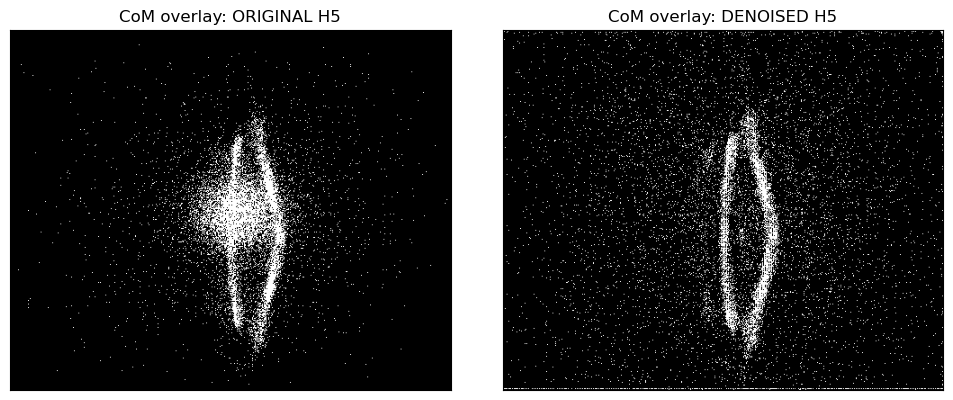

In [13]:
# ---- Option B (CPU-friendly): CoM overlay comparison using ORIGINAL vs DENOISED HDF5 ----
# This cell does *no model inference*. It compares:
#   - original frames from H5_PATH
#   - denoised frames from a separate DENOISED_H5_PATH

from pathlib import Path

try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

DENOISED_H5_PATHS = [
    r"D:\Project_PostDoc\Hackathon\old_runs\sort\reconst\denoised_23316432.h5"
]
DENOISED_H5_PATH = next((p for p in DENOISED_H5_PATHS if p and os.path.exists(p)), None)

if DENOISED_H5_PATH is None:
    raise FileNotFoundError("Set DENOISED_H5_PATHS to point to your locally-copied denoised HDF5.")

MAX_Y_ROWS = None  # set to None for all rows or a number for a subset
USE_CACHE = True

CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Include MAX_Y_ROWS in the cache filename so partial runs don't collide with full runs.
max_tag = "all" if MAX_Y_ROWS is None else f"rows{int(MAX_Y_ROWS)}"
CACHE_PATH = CACHE_DIR / (
    f"com_overlay_from_h5_{max_tag}_pct{COM_THRESH_PCT}_"
    f"orig{Path(H5_PATH).stem}_den{Path(DENOISED_H5_PATH).stem}.npz"
)


def _get_dset(f: h5py.File) -> h5py.Dataset:
    for k in H5_KEY_CANDIDATES:
        if k in f:
            return f[k]
    raise KeyError(f"Could not find dataset key in {list(f.keys())}")


def _mark_com(m: np.ndarray, yc: float, xc: float) -> None:
    if not (np.isfinite(yc) and np.isfinite(xc)):
        return
    iy = int(round(float(yc)))
    ix = int(round(float(xc)))
    if 0 <= iy < m.shape[0] and 0 <= ix < m.shape[1]:
        m[iy, ix] = 1.0


if USE_CACHE and CACHE_PATH.exists():
    data = np.load(CACHE_PATH)
    COM_MAP_INPUT_H5 = data["com_map_input"]
    COM_MAP_DENOISED_H5 = data["com_map_denoised"]
    print("Loaded cached CoM overlays:", CACHE_PATH)
else:
    with h5py.File(H5_PATH, "r") as f0, h5py.File(DENOISED_H5_PATH, "r") as f1:
        d0 = _get_dset(f0)
        d1 = _get_dset(f1)

        if d0.shape != d1.shape:
            raise ValueError(f"Shape mismatch: original={d0.shape} denoised={d1.shape}")
        if d0.ndim != 4:
            raise ValueError(f"Expected (sy,sx,H,W) datasets; got ndim={d0.ndim}")

        sy2, sx2, dety2, detx2 = (int(x) for x in d0.shape)
        y_do = sy2 if MAX_Y_ROWS is None else min(int(MAX_Y_ROWS), sy2)

        COM_MAP_INPUT_H5 = np.zeros((dety2, detx2), dtype=np.float32)
        COM_MAP_DENOISED_H5 = np.zeros((dety2, detx2), dtype=np.float32)

        y_iter = range(y_do)
        if tqdm is not None:
            y_iter = tqdm(y_iter, total=y_do, desc="CoM overlays from H5 (orig vs denoised)")

        for yy in y_iter:
            row0 = np.asarray(d0[int(yy), :, :, :], dtype=np.float32)
            row1 = np.asarray(d1[int(yy), :, :, :], dtype=np.float32)

            for xx in range(int(sx2)):
                yc0, xc0 = _center_of_mass_2d(_threshold_for_com(row0[xx]))
                yc1, xc1 = _center_of_mass_2d(_threshold_for_com(row1[xx]))
                _mark_com(COM_MAP_INPUT_H5, yc0, xc0)
                _mark_com(COM_MAP_DENOISED_H5, yc1, xc1)

    np.savez_compressed(
        CACHE_PATH,
        com_map_input=COM_MAP_INPUT_H5,
        com_map_denoised=COM_MAP_DENOISED_H5,
        orig_h5=str(H5_PATH),
        denoised_h5=str(DENOISED_H5_PATH),
        com_thresh_pct=np.float32(COM_THRESH_PCT),
        max_y_rows=(-1 if MAX_Y_ROWS is None else int(MAX_Y_ROWS)),
    )
    print("Saved cached CoM overlays:", CACHE_PATH)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax[0].imshow(COM_MAP_INPUT_H5, cmap="gray")
ax[0].set_title("CoM overlay: ORIGINAL H5")
ax[1].imshow(COM_MAP_DENOISED_H5, cmap="gray")
ax[1].set_title("CoM overlay: DENOISED H5")
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
plt.show()



In [ ]:
# (optional)
